## XQ1i interactive UI

This notebook guides the user through the calibration and control of the four qubits (QBs) available with the XQ1i quantum processor:
- QB1: NV electron spin
- QB2: nitrogen ($^{14}$N) nuclear spin
- QB3: carbon ($^{13}$C$_1$) nuclear spin
- QB4: carbon ($^{13}$C$_2$) nuclear spin

The first notebook cell imports the xq1i library (`libxq1i`) along with some other python modules to establish the communication to and initialization of the device. During initialization, the last saved calibration parameters are loaded from the hard drive (contained in the subfolder `calib_params`). In case the loaded calibration parameters are deemed to be outdated, a warning is printed. In such a case re-running the calibration cell is recommended.

In [60]:
import time
import datetime
import os
import json
import numpy as np
import matplotlib.pyplot as plt

import importlib
import libxq1i
importlib.reload(libxq1i)

try: 
   pulsed_master_logic
except NameError:
   manager.startModule('logic', 'pulsed_master_logic')

xq1i = libxq1i.xq1i(pulsed_master_logic, pulsed_measurement_logic, sequence_generator_logic)

INFO: loaded calibration parameters from file 'calib_params_20240505_1346.json'


### Calibration cell
The following notebook cell performs the calibration of the qubits in the system by determining the resonance frequencies of the relevant state transitions and their driving periods.

In [ ]:
# calibration of QB1
xq1i.qb1_calibration()

In [ ]:
# calibration of QB2 (either "partial" [no DDRF calib] or "full" [including DDRF calib])
xq1i.qb2_calibration(type='partial')

In [ ]:
# calibration of QB3
xq1i.qb3_calibration()

In [ ]:
# calibration of QB4
xq1i.qb4_calibration()

### Example 1: execution of a two-qubit circuit
The next cell defines a quantum circuit for a calibrated two-qubit system (consisting of QB1 and QB2), executes it, and outputs the measured final populations of the four computational basis states. The measurement results are saved into the subfolder `measurement_results`.

The computational basis states are:
- `00`: $|0\rangle_\textrm{el} \otimes |0\rangle_\textrm{14N}$
- `01`: $|0\rangle_\textrm{el} \otimes |1\rangle_\textrm{14N}$
- `10`: $|1\rangle_\textrm{el} \otimes |0\rangle_\textrm{14N}$
- `11`: $|1\rangle_\textrm{el} \otimes |1\rangle_\textrm{14N}$

Any of the computational basis states can be chosen as the initial state of the circuit.

The quantum circuit is defined as a list of native gates. Each gate of the circuit takes the following parameters:
- gate name
- qubit acted upon
- optional gate parameter (only relvant for some gates, see list of native gates below)

The following native gates are available:
- `sx(n)`: $\sqrt{X}$, performs a $\pi/2$ rotation on qubit $n$ (with $n \in \{1,2\}$) along the x-axis of the Bloch sphere
- `rz(n)[theta]`: $R_z(\theta)$, performs a rotation by angle $\theta$ along the z-axis on qubit $n$ (with $n \in \{1,2\}$), where $\theta$ is provided as optional gate parameter (unit: degrees)
- `noop[t_delay]`: delays the execution of all subsequent gates in the circuit by a duration $t_\mathrm{delay} \geq 0$, where $t_\mathrm{delay}$ is provided as optional gate parameter (unit: seconds)
- `c0x(n)`: controlled NOT of qubit $n$ (with $n \in \{1,2\}$) if the control qubit $c$ (with $c=2$ if $n=1$, and vice versa) is in state 0
- `c1x(n)`: controlled NOT of qubit $n$ (with $n \in \{2\}$) if the control qubit $c$ (with $c \in \{1\}$) is in state 1

measuring population of state 00 ...


 ... quantumcircuitQB12:   0%|          | 0/60000.0 [00:00<?, ?sweeps/s]

measuring population of state 01 ...


 ... quantumcircuitQB12:   0%|          | 0/60000.0 [00:00<?, ?sweeps/s]

measuring population of state 10 ...


 ... quantumcircuitQB12:   0%|          | 0/60000.0 [00:00<?, ?sweeps/s]

measuring population of state 11 ...


 ... quantumcircuitQB12:   0%|          | 0/60000.0 [00:00<?, ?sweeps/s]

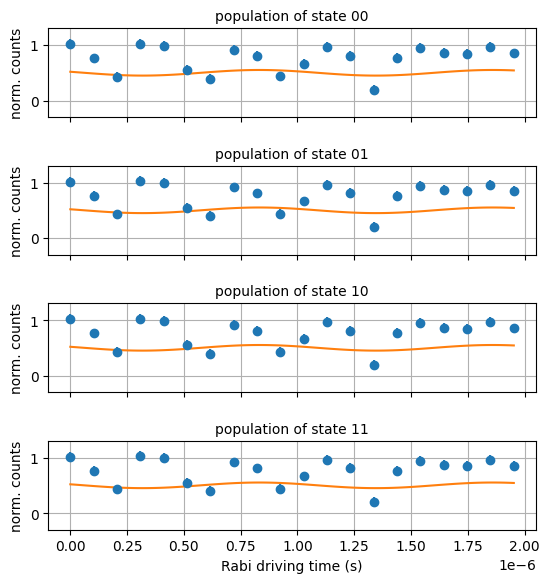

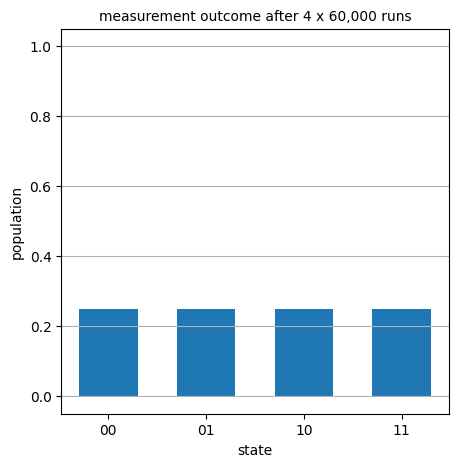

In [61]:
sweeps = 60e3
initState = libxq1i.TQstates.State00
qcQB12 = [
    xq1i.gate("sx", 1),
    xq1i.gate("sx", 2),
    xq1i.gate("c0x", 2),
    xq1i.gate("c0x", 1),
]
xq1i.run_quantum_circuit(ciruit=qcQB12, initState=initState, sweeps=sweeps)

### Example 2: execution of a three-qubit circuit
The next cell defines a quantum circuit for a calibrated three-qubit system (QB1, QB2, QB3), executes it, and outputs the measured final populations of the eight computational basis states. The measurement results are saved into the subfolder `measurement_results`.

The computational basis states are in this case:
- `000`: $|0\rangle_\textrm{el} \otimes |0\rangle_\textrm{14N} \otimes |0\rangle_{\textrm{13C}_1}$
- `001`: $|0\rangle_\textrm{el} \otimes |0\rangle_\textrm{14N} \otimes |1\rangle_{\textrm{13C}_1}$
- `010`: $|0\rangle_\textrm{el} \otimes |1\rangle_\textrm{14N} \otimes |0\rangle_{\textrm{13C}_1}$
- `011`: $|0\rangle_\textrm{el} \otimes |1\rangle_\textrm{14N} \otimes |1\rangle_{\textrm{13C}_1}$
- `100`: $|1\rangle_\textrm{el} \otimes |0\rangle_\textrm{14N} \otimes |0\rangle_{\textrm{13C}_1}$
- `101`: $|1\rangle_\textrm{el} \otimes |0\rangle_\textrm{14N} \otimes |1\rangle_{\textrm{13C}_1}$
- `110`: $|1\rangle_\textrm{el} \otimes |1\rangle_\textrm{14N} \otimes |0\rangle_{\textrm{13C}_1}$
- `111`: $|1\rangle_\textrm{el} \otimes |1\rangle_\textrm{14N} \otimes |1\rangle_{\textrm{13C}_1}$

The gate set listed above for the two-qubit example is now extended by the following three additional gates:
- `sx(3)`: $\sqrt{X}$, performs a $\pi/2$ rotation on QB3 along the x-axis of the Bloch sphere
- `rz(3)[theta]`: $R_z(\theta)$, performs a rotation by angle $\theta$ along the z-axis on QB3
- `crotx(3)`: $|0\rangle\langle 0|^{(c)} \otimes R_x^{(n)}\left(\frac{\pi}{2}\right) + |1\rangle\langle 1|^{(c)} \otimes R_x^{(n)}\left(-\frac{\pi}{2}\right)$, conditional rotation of QB3 ($n \in \{3\}$), with QB1 being the control qubit ($c \in \{1\}$)

In [ ]:
sweeps = 50e3
initState = libxq1i.ThrQstates.State000
qcQB123 = [
    xq1i.gate("sx", 1),
    xq1i.gate("sx", 2),
    xq1i.gate("c0x", 2),
    xq1i.gate("sx", 3),
    xq1i.gate("rz", 3, 45),
    xq1i.gate("crotx", 3),
]
xq1i.run_quantum_circuit(ciruit=qcQB123, initState=initState, sweeps=sweeps)

measuring population of state 1 ...


 ... quantumcircuitQB123:   0%|          | 0/50000.0 [00:00<?, ?sweeps/s]

measuring population of state 2 ...


 ... quantumcircuitQB123:   0%|          | 0/50000.0 [00:00<?, ?sweeps/s]

measuring population of state 3 ...


 ... quantumcircuitQB123:   0%|          | 0/50000.0 [00:00<?, ?sweeps/s]

measuring population of state 4 ...


 ... quantumcircuitQB123:   0%|          | 0/50000.0 [00:00<?, ?sweeps/s]

measuring population of state 5 ...


 ... quantumcircuitQB123:   0%|          | 0/50000.0 [00:00<?, ?sweeps/s]